In [46]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy

import numpy as np
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from caterpillar import catalog

### COSMOS Dwarf Catalog

In [2]:
merian_dir = '/Users/song/Downloads/merian/'

cosmos_cat = Table.read(os.path.join(merian_dir, 'cosmos', 'COSMOS_dwarfs_Merian.fits'))

print(len(cosmos_cat))
print(cosmos_cat.colnames)

227
['ALPHA_J2000', 'DELTA_J2000', 'z_cosmos', 'mass_cosmos']


In [8]:
from unagi import hsc
from unagi import task
from unagi import query
from unagi import config
from unagi import catalog
from unagi import plotting

s20a_w = hsc.Hsc(dr='dr3', rerun='s20a_wide')
s20a_d = hsc.Hsc(dr='dr3', rerun='s20a_dud')

# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_wide/s20a_wide_tables.fits
# Get table list from /Users/song/Dropbox/work/project/unagi/unagi/data/s20a_dud/s20a_dud_tables.fits


In [11]:
cosmos_cat.add_column(Column(data=np.arange(len(cosmos_cat)) + 1, name='index'))

In [12]:
for obj in cosmos_cat:
    
    coord = SkyCoord(obj['ALPHA_J2000'], obj['DELTA_J2000'], frame='icrs', unit='deg')
    
    # Use angular size and don't save the data
    cutout_rgb, cutout_wcs = task.hsc_tricolor(
        coord, cutout_size=(10.0 * u.arcsec), filters='gri', verbose=False, 
        save_rgb=False, save_img=False, use_saved=False, archive=s20a_d)

    fig_1 = plt.figure(figsize=(8, 8))
    ax1 = fig_1.add_subplot(111)
    ax1.grid(False)
    ax1 = plotting.display_single(
        cutout_rgb, ax=ax1, contrast=0.1, scale_bar_length=5, scale_bar_color='w')
    
    fig_1.savefig(
        '/Users/song/Downloads/merian/cosmos/cosmos_dwarf_{:d}_gri.png'.format(obj['index']))
    plt.close(fig_1)
    
    cutout_objs = task.hsc_box_search(
        coord, box_size=(10.0 * u.arcsec), redshift=None, archive=s20a_w,
        verbose=False, psf=True, cmodel=True, aper=False, shape=True,
        meas='i', flux=False, aper_type='3_20')
    
    fig_2 = plotting.cutout_show_objects(
        cutout_rgb, cutout_objs, show_clean=False, xsize=10, band='i', scale_bar_color='w',
        show_mag=False, show_weighted=True, cutout_wcs=cutout_wcs, scale_bar_length=5,
        verbose=False)
    
    fig_2.savefig(
        '/Users/song/Downloads/merian/cosmos/cosmos_dwarf_{:d}_cmodel.png'.format(obj['index']))
    plt.close(fig_2)

Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]


/Users/song/Dropbox/work/project/unagi/unagi/plotting.py:732: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data)) * 255


Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for query to finish... [Done]
Waiting for 

### HSC PDR2-Wide COSMOS catalog

In [17]:
pdr2_cat = os.path.join(merian_dir, 'cosmos', 'pdr2_cosmos_wide_broad_cut.fits')
pdr2_cos = Table.read(pdr2_cat)

print(len(pdr2_cos))

48133


In [20]:
mask_dir = '/Users/song/astro1/hsc/bright_star_new/'

pdr2_cos_bsm = catalog.filter_through_bright_star_mask(pdr2_cat, mask_dir)

In [43]:
len(pdr2_cos_bsm)

32956

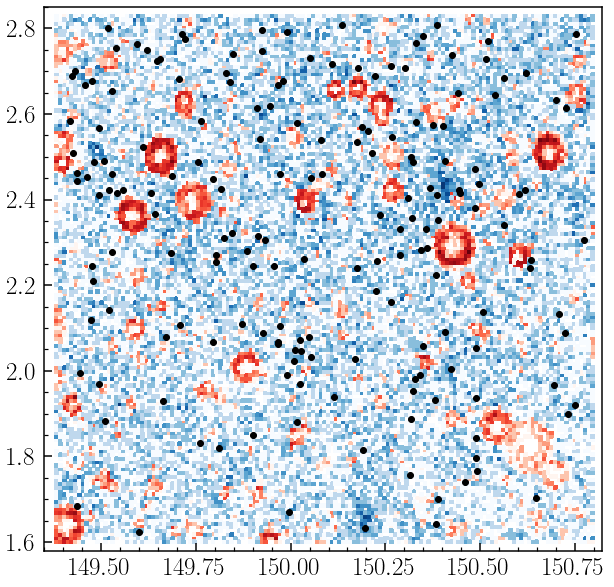

In [53]:
plt.figure(figsize=(10, 10))

_ = plt.hist2d(pdr2_cos['ra'], pdr2_cos['dec'], bins=(150, 150), norm=mpl.colors.LogNorm(),
               range=[[149.35, 150.82], [1.58, 2.85]], cmap='Reds', edgecolor='none')

_ = plt.hist2d(pdr2_cos_bsm['ra'], pdr2_cos_bsm['dec'], bins=(150, 150), alpha=1.0, norm=mpl.colors.LogNorm(),
               range=[[149.35, 150.82], [1.58, 2.85]], cmap='Blues', edgecolor='none')

plt.scatter(pdr2_match_bsm['ra'], pdr2_match_bsm['dec'], c='k')

### Matched dwarfs

In [22]:
pdr2_match_cat = os.path.join(merian_dir, 'cosmos', 'pdr2_cosmos_dwarf_match_5arcsec.fits')


pdr2_match_bsm = catalog.filter_through_bright_star_mask(pdr2_match_cat, mask_dir)

print(len(pdr2_match_bsm))

180


### Distribution of color and size

In [54]:
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='i_sdss_shape', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='i_cmodel_ellipse', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_cos_bsm = catalog.moments_to_shape(pdr2_cos_bsm, shape_type='r_cmodel_ellipse', update=True)

In [55]:
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='i_sdss_shape', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='i_cmodel_exp_ellipse', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='i_cmodel_ellipse', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='r_cmodel_exp_ellipse', update=True)
pdr2_match_bsm = catalog.moments_to_shape(pdr2_match_bsm, shape_type='r_cmodel_ellipse', update=True)

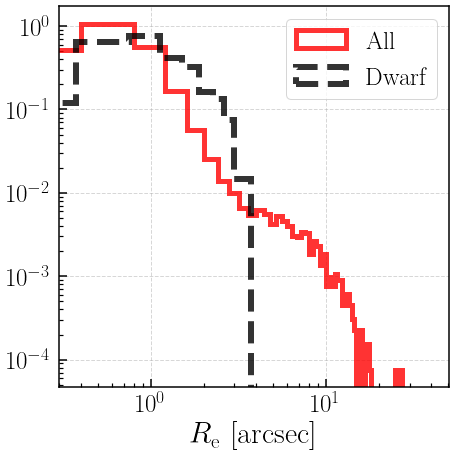

In [81]:
plt.figure(figsize=(7, 7))
plt.loglog()

_ = plt.hist(pdr2_cos_bsm['i_cmodel_exp_ellipse_r'], range=(0, 40), bins=100, histtype='step', 
             color='red', linewidth=5, alpha=0.8, label=r'$\rm All$', density=True)

_ = plt.hist(pdr2_match_bsm['i_cmodel_exp_ellipse_r'], range=(0, 15), bins=40, histtype='step', 
             color='k', linewidth=6, linestyle='--', alpha=0.8, label=r'$\rm Dwarf$', density=True)

plt.legend(fontsize=25)

_ = plt.xlabel(r'$R_{\rm e}\ [\rm arcsec]$', fontsize=30)

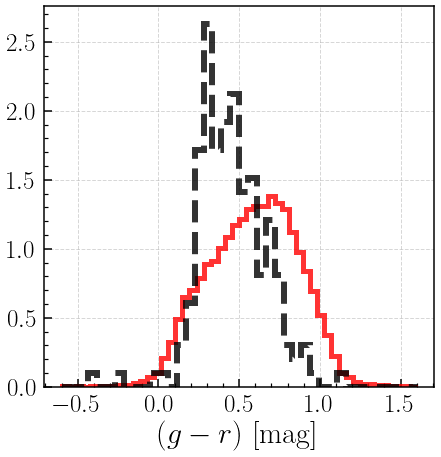

In [82]:
plt.figure(figsize=(7, 7))

_ = plt.hist(pdr2_cos_bsm['g_cmodel_mag'] - pdr2_cos_bsm['r_cmodel_mag'], 
             range=(-0.6, 1.6), bins=50, histtype='step', 
             color='red', linewidth=5, alpha=0.8, label=r'$\rm All$', density=True)

_ = plt.hist(pdr2_match_bsm['g_cmodel_mag'] - pdr2_match_bsm['r_cmodel_mag'], 
             range=(-0.6, 1.6), bins=40, histtype='step', 
             color='k', linewidth=6, linestyle='--', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = plt.xlabel(r'$(g-r)\ [\rm mag]$', fontsize=30)

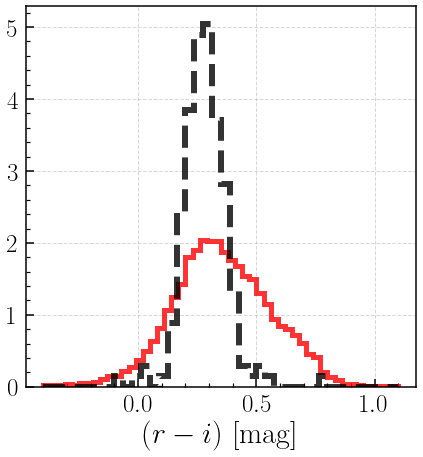

In [87]:
plt.figure(figsize=(7, 7))

_ = plt.hist(pdr2_cos_bsm['r_cmodel_mag'] - pdr2_cos_bsm['i_cmodel_mag'], 
             range=(-0.4, 1.1), bins=50, histtype='step', 
             color='red', linewidth=5, alpha=0.8, label=r'$\rm All$', density=True)

_ = plt.hist(pdr2_match_bsm['r_cmodel_mag'] - pdr2_match_bsm['i_cmodel_mag'], 
             range=(-0.4, 1.1), bins=40, histtype='step', 
             color='k', linewidth=6, linestyle='--', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = plt.xlabel(r'$(r-i)\ [\rm mag]$', fontsize=30)

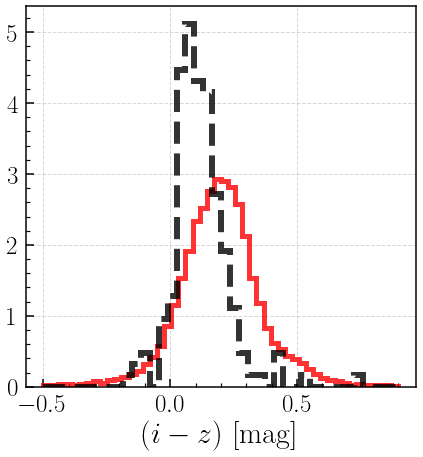

In [90]:
plt.figure(figsize=(7, 7))

_ = plt.hist(pdr2_cos_bsm['i_cmodel_mag'] - pdr2_cos_bsm['z_cmodel_mag'], 
             range=(-0.5, 0.9), bins=50, histtype='step', 
             color='red', linewidth=5, alpha=0.8, label=r'$\rm All$', density=True)

_ = plt.hist(pdr2_match_bsm['i_cmodel_mag'] - pdr2_match_bsm['z_cmodel_mag'], 
             range=(-0.5, 0.9), bins=40, histtype='step', 
             color='k', linewidth=6, linestyle='--', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = plt.xlabel(r'$(i-z)\ [\rm mag]$', fontsize=30)

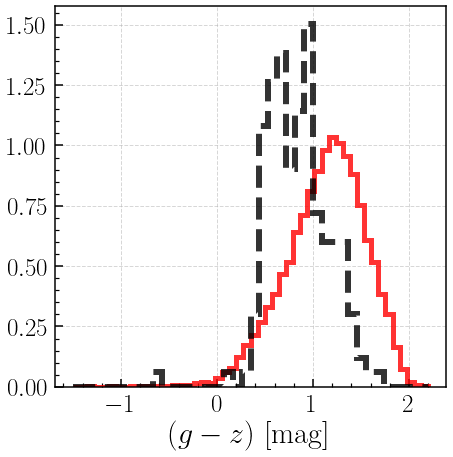

In [93]:
plt.figure(figsize=(7, 7))

_ = plt.hist(pdr2_cos_bsm['g_cmodel_mag'] - pdr2_cos_bsm['z_cmodel_mag'], 
             range=(-1.5, 2.2), bins=50, histtype='step', 
             color='red', linewidth=5, alpha=0.8, label=r'$\rm All$', density=True)

_ = plt.hist(pdr2_match_bsm['g_cmodel_mag'] - pdr2_match_bsm['z_cmodel_mag'], 
             range=(-1.5, 2.2), bins=40, histtype='step', 
             color='k', linewidth=6, linestyle='--', alpha=0.8, label=r'$\rm Dwarf$', density=True)

_ = plt.xlabel(r'$(g-z)\ [\rm mag]$', fontsize=30)

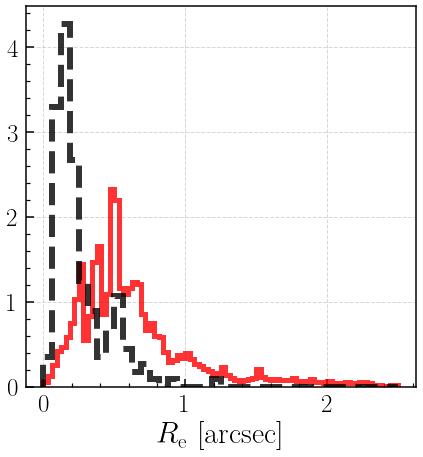

In [95]:
plt.figure(figsize=(7, 7))
#plt.loglog()

_ = plt.hist(pdr2_cos_bsm['photoz_best'], range=(0, 2.5), bins=80, histtype='step', 
             color='red', linewidth=5, alpha=0.8, label=r'$\rm All$', density=True)

_ = plt.hist(pdr2_match_bsm['photoz_best'], range=(0, 2.5), bins=40, histtype='step', 
             color='k', linewidth=6, linestyle='--', alpha=0.8, label=r'$\rm Dwarf$', density=True)


_ = plt.xlabel(r'$R_{\rm e}\ [\rm arcsec]$', fontsize=30)